有无数的导数公式, 不可能把他们全部都背下来. 如果我们想知道 一个导数的公式. 我们可以使用一些工具 .


## 1. 用计算机代数系统计算精确的导数 .

`Mathematica` 是最流行的 计算机代数系统之一, 可以在 Wolfram Alpha 在获取.

这是个非常牛的网站. 有自己的语法 . 但是对输入很兼容  比如说 `python` 语法就能完全的支持 .

例如, 输入:
1/1(1+e**(-x)) . 这个函数不仅仅是导数, 各种东西就全部出来了. 导数是 `Derivative` 那段的 .

$$
f^{'}(x) = \frac{e^{-x}}{(1 + e^{-x})^2}
$$

如果你理解了 导数和变化率的概念. 那么最重要的技能之一就是学一下 他的语法 .

当然作为数学爱好者, 学习一下 推导过程也是很有趣的

$$
f(x) = (3x^2 + x)sin(x)
$$

In [1]:
# python 中的语法如下:

from math import sin


def f(x):
    return (3 * x ** 2 + x) * sin(x)

我们的策略是 把代数表达式建模为 数据结构, 而不是直接翻译为 `python` 代码, 意思是工程上也要玩一下先 .


### 1.1 将表达式拆分为若干个部分 .

比如说分为2个部分

$$3x^2 + x$$ 和 $$sin(x)$$

在函数式编程的术语中, 这种把较小对象合成较大对象的函数通常称为 组合器. 下面是隐含的组合器 .

- 3x^2 是表达式 3 和 x^2 的乘法, 也就是幂运算好像 > 乘法运算的优先级
- sin(x) 是一个函数应用, 给定表达式 sin 和 x 可以建立一个新的 表达式 sin(x)

### 1.2 构建表达式树 .

幂
- x
- 2

就是用 幂运算把 x 和 2 结合起来 .

下一步则是把上面的结果 x^2 和 3 用乘法结合

乘法
- x^2
- 3

这种结构中: 输入乘法组合器的表达式本身也是1个组合器.

这个结构会越来越深 , 也就是 最典型 的树状结构 .

- 树的根是一个乘法组合器 .
- 有2个分支

### 1.3 用 Python 语言实现表达式树

In [2]:
class Power():
    def __init__(self, base, exponent):
        self.base = base
        self.exponent = exponent


class Number():
    # 数
    def __init__(self, number):
        self.number = number


class Variable():
    # 变量
    def __init__(self, symbol):
        self.symbol = symbol


Power(Variable("x"), Number(2))

每 一个组合器都可以被实现为一个具名的类, 用来存储它所组合的任意表达式的数据 .

例如: 乘法组合起可以是 2个相乘表达式的类 .

In [3]:
class Product():
    def __init__(self, exp1, exp2):
        self.exp1 = exp1
        self.exp2 = exp2

In [4]:
Product(Number(3), Power(Variable("x"), Number(2)))

In [5]:
class Sum():
    def __init__(self, *exps):  #<1> 允许计算任意多个和 .
        self.exps = exps


class Function():  #<2> 使用字符串存储函数名称,例如 sin
    def __init__(self, name):
        self.name = name


class Apply():  #<3> 存储1个函数以及传入函数的参数
    def __init__(self, function, argument):
        self.function = function
        self.argument = argument


f_expression = Product(  #<4> 表达了 (3 x^2 + x)sin(x) 的准确表示
    Sum(
        Product(
            Number(3),
            Power(
                Variable("x"),
                Number(2))),
        Variable("x")),
    Apply(
        Function("sin"),
        Variable("x")))

理解下面的 表达式代表了 .

$$
cos(x^3-5)
$$


In [6]:
Apply(Function("cos"), Sum(Power(Variable("x"), Number("3")), Number(-5)))

### 1.4 exercises

**exec1**: 自然对数是一种特殊的数学函数, 写做 ln(x) .

In [7]:
Apply(
    Function("ln"),
    Power(Variable("y"), Number("z"))
)

In [8]:
from math import log


def f(y, z):
    return log(y ** z)

**exec2**: 实现一个 Quotient 表示2个表达式 相除, 相减

In [9]:
class Quotient():
    def __init__(self, numerator, denominator):
        self.numerator = numerator
        self.denominator = denominator


class Difference():
    def __init__(self, exp1, exp2):
        self.exp1 = exp1
        self.exp2 = exp2


class Negative():
    def __init__(self, exp):
        self.exp = exp

## 2. 符号表达式的应用


### 2.1 寻找表达式中的所有变量.


现在来实现 一个函数, 它接收1个表达式并返回其中不同变量的列表 .

例如:
$$h(z) = 2z + 3$$ 包含了 z.

$$g(x) = 7 $$ 中不包含任何变量 .

我们可以写一个函数 `distinct_variables`
- 接收1个表达式 (任何的元素或者组合器) ;
- 返回 1个包含变量的 `Python` 集合 ;

这时候可以使用递归 简化我们的代码, 毕竟我们现在不追求性能 .

In [10]:
def distinct_variables(exp):
    if isinstance(exp, Variable):
        return set(exp.symbol)
    elif isinstance(exp, Number):
        return set()
    elif isinstance(exp, Sum):
        return set().union(*[distinct_variables(exp) for exp in exp.exps])
    elif isinstance(exp, Product):
        return distinct_variables(exp.exp1).union(distinct_variables(exp.exp2))
    elif isinstance(exp, Power):
        return distinct_variables(exp.base).union(distinct_variables(exp.exponent))
    elif isinstance(exp, Apply):
        return distinct_variables(exp.argument)
    else:
        raise TypeError("Not a valid expression.")

In [11]:
distinct_variables(Variable("z"))

{'z'}

In [12]:
distinct_variables(Number(3))

set()

In [13]:
distinct_variables(f_expression)

{'x'}

### 2.2 计算表达式的值.

我们已经的得到了 代码表达形式 .

简单的说, 计算一个函数 f(x) 的值, 意味着把函数中所有的 x 都替换为 5 然后去计算.

和寻找变量的一样的, 我们也是写 if -else 然后递归 .

1. 首先 我们要知道需要替换哪些变量， 替换为 什么值
    - 计算机中 这可以叫做 `variable  binding`
2. 然后, 我们使用另外的代码风格来做

In [14]:
from abc import ABC, abstractmethod


class Expression(ABC):
    @abstractmethod
    def evaluate(self, **bindings):
        pass


class Number(Expression):
    def __init__(self, number):
        self.number = number

    def evaluate(self, **bindings):
        return self.number


class Variable(Expression):
    def __init__(self, symbol):
        self.symbol = symbol

    def evaluate(self, **bindings):
        try:
            return bindings[self.symbol]
        except:
            raise KeyError("Variable '{}' is not bound.".format(self.symbol))


class Product(Expression):
    """
    新的乘法 .
    """

    def __init__(self, exp1, exp2):
        self.exp1 = exp1
        self.exp2 = exp2

    def evaluate(self, **bindings):
        return self.exp1.evaluate(**bindings) * self.exp2.evaluate(**bindings)

In [15]:
Product(Variable("x"), Variable("y")).evaluate(x=2, y=5)

10

同样的思路 ,我们可以为 其他的也做这个工作 .

注意 Apply 组合器的工作方式不同, 需要动态的查看函数名, 例如 `sin` 或者 `Sqrt` .

需要找到对应的函数, 简单来做也是 `if-else`

In [16]:
import math
from math import sin, cos, log

_function_bindings = {
    "sin": math.sin,
    "cos": math.cos,
    "ln": math.log
}


class Apply(Expression):
    def __init__(self, function, argument):
        self.function = function
        self.argument = argument

    def evaluate(self, **bindings):
        return _function_bindings[self.function.name](self.argument.evaluate(**bindings))


class Sum(Expression):
    def __init__(self, *exps):
        self.exps = exps

    def evaluate(self, **bindings):
        return sum([exp.evaluate(**bindings) for exp in self.exps])


class Power(Expression):
    def __init__(self, base, exponent):
        self.base = base
        self.exponent = exponent

    def evaluate(self, **bindings):
        return self.base.evaluate(**bindings) ** self.exponent.evaluate(**bindings)


class Difference(Expression):
    def __init__(self, exp1, exp2):
        self.exp1 = exp1
        self.exp2 = exp2

    def evaluate(self, **bindings):
        return self.exp1.evaluate(**bindings) - self.exp2.evaluate(**bindings)


class Quotient(Expression):
    def __init__(self, numerator, denominator):
        self.numerator = numerator
        self.denominator = denominator

    def evaluate(self, **bindings):
        return self.numerator.evaluate(**bindings) / self.denominator.evaluate(**bindings)

In [17]:
f_expression = Product(  #<4>
    Sum(
        Product(
            Number(3),
            Power(
                Variable("x"),
                Number(2))),
        Variable("x")),
    Apply(
        Function("sin"),
        Variable("x")))

f_expression.evaluate(x=5)

-76.71394197305108

校验一下发现是相同的 .

In [18]:
from math import sin


def f(x):
    return (3 * x ** 2 + x) * sin(x)


f(5)

-76.71394197305108

### 2.3 表达式的展开

我们还可以用表达式结构做很多事情 .

在看之前的需求: 表达式展开 .

这意味着将和的任意乘积或者 幂运算都搞出来

在代数中有很多律 .

例如: $$(a + b)c = ac + bc$$

这就是一个展开

In [19]:
class Expression(ABC):
    @abstractmethod
    def evaluate(self, **bindings):
        pass

    @abstractmethod
    def expand(self):
        pass

    # Printing expressions legibly in REPL (See first mini project in 2.4)
    @abstractmethod
    def display(self):
        pass

    def __repr__(self):
        return self.display()

In [20]:
class Sum(Expression):
    def __init__(self, *exps):
        self.exps = exps

    def evaluate(self, **bindings):
        return sum([exp.evaluate(**bindings) for exp in self.exps])

    def expand(self):
        return Sum(*[exp.expand() for exp in self.exps])

    def display(self):
        return "Sum({})".format(",".join([e.display() for e in self.exps]))


class Product(Expression):
    def __init__(self, exp1, exp2):
        self.exp1 = exp1
        self.exp2 = exp2

    def evaluate(self, **bindings):
        return self.exp1.evaluate(**bindings) * self.exp2.evaluate(**bindings)

    def expand(self):
        expanded1 = self.exp1.expand()
        expanded2 = self.exp2.expand()
        if isinstance(expanded1, Sum):
            return Sum(*[Product(e, expanded2).expand() for e in expanded1.exps])
        elif isinstance(expanded2, Sum):
            return Sum(*[Product(expanded1, e) for e in expanded2.exps])
        else:
            return Product(expanded1, expanded2)

    def display(self):
        return "Product({},{})".format(self.exp1.display(), self.exp2.display())


class Difference(Expression):
    def __init__(self, exp1, exp2):
        self.exp1 = exp1
        self.exp2 = exp2

    def evaluate(self, **bindings):
        return self.exp1.evaluate(**bindings) - self.exp2.evaluate(**bindings)

    def expand(self):
        return self

    def display(self):
        return "Difference({},{})".format(self.exp1.display(), self.exp2.display())


class Quotient(Expression):
    def __init__(self, numerator, denominator):
        self.numerator = numerator
        self.denominator = denominator

    def evaluate(self, **bindings):
        return self.numerator.evaluate(**bindings) / self.denominator.evaluate(**bindings)

    def expand(self):
        return self

    def display(self):
        return "Quotient({},{})".format(self.numerator.display(), self.denominator.display())


class Negative(Expression):
    def __init__(self, exp):
        self.exp = exp

    def evaluate(self, **bindings):
        return - self.exp.evaluate(**bindings)

    def expand(self):
        return self

    def display(self):
        return "Negative({})".format(self.exp.display())


class Number(Expression):
    def __init__(self, number):
        self.number = number

    def evaluate(self, **bindings):
        return self.number

    def expand(self):
        return self

    def display(self):
        return "Number({})".format(self.number)


class Power(Expression):
    def __init__(self, base, exponent):
        self.base = base
        self.exponent = exponent

    def evaluate(self, **bindings):
        return self.base.evaluate(**bindings) ** self.exponent.evaluate(**bindings)

    def expand(self):
        return self

    def display(self):
        return "Power({},{})".format(self.base.display(), self.exponent.display())


class Variable(Expression):
    def __init__(self, symbol):
        self.symbol = symbol

    def evaluate(self, **bindings):
        return bindings[self.symbol]

    def expand(self):
        return self

    def display(self):
        return "Variable(\"{}\")".format(self.symbol)


class Function():
    def __init__(self, name, make_latex=None):
        self.name = name
        self.make_latex = make_latex

    def latex(self, arg_latex):
        if self.make_latex:
            return self.make_latex(arg_latex)
        else:
            return " \\operatorname{{ {} }} \\left( {} \\right)".format(self.name, arg_latex)


class Apply(Expression):
    def __init__(self, function, argument):
        self.function = function
        self.argument = argument

    def evaluate(self, **bindings):
        return _function_bindings[self.function.name](self.argument.evaluate(**bindings))

    def expand(self):
        return Apply(self.function, self.argument.expand())

    def display(self):
        return "Apply(Function(\"{}\"),{})".format(self.function.name, self.argument.display())

In [21]:
Y = Variable('y')
Z = Variable('z')
A = Variable('a')
B = Variable('b')
Product(Sum(A, B), Sum(Y, Z))

Product(Sum(Variable("a"),Variable("b")),Sum(Variable("y"),Variable("z")))

In [22]:
Product(Sum(A, B), Sum(Y, Z)).expand()

Sum(Sum(Product(Variable("a"),Variable("y")),Product(Variable("a"),Variable("z"))),Sum(Product(Variable("b"),Variable("y")),Product(Variable("b"),Variable("z"))))

In [23]:
f_expression = Product(  #<4>
    Sum(
        Product(
            Number(3),
            Power(
                Variable("x"),
                Number(2))),
        Variable("x")),
    Apply(
        Function("sin"),
        Variable("x")))

f_expression.expand()

Sum(Product(Product(Number(3),Power(Variable("x"),Number(2))),Apply(Function("sin"),Variable("x"))),Product(Variable("x"),Apply(Function("sin"),Variable("x"))))

### 2.4 exercises

**exec1:** 写1个 contains 函数, 类似之前的 set 函数 .


In [24]:
def contains(exp, var):
    if isinstance(exp, Variable):
        return exp.symbol == var.symbol
    elif isinstance(exp, Number):
        return False
    elif isinstance(exp, Sum):
        return any([contains(e, var) for e in exp.exps])
    elif isinstance(exp, Product):
        return contains(exp.exp1, var) or contains(exp.exp2, var)
    elif isinstance(exp, Power):
        return contains(exp.base, var) or contains(exp.exponent, var)
    elif isinstance(exp, Apply):
        return contains(exp.argument, var)
    else:
        raise TypeError("Not a valid expression.")

**exec2:** : 实现1个 distinct_functions 函数, 接收1个表达式作为承诺书, 并返回表达式中不重复的函数 .

In [25]:
def distinct_functions(exp):
    if isinstance(exp, Variable):
        return set()
    elif isinstance(exp, Number):
        return set()
    elif isinstance(exp, Sum):
        return set().union(*[distinct_functions(exp) for exp in exp.exps])
    elif isinstance(exp, Product):
        return distinct_functions(exp.exp1).union(distinct_functions(exp.exp2))
    elif isinstance(exp, Power):
        return distinct_functions(exp.base).union(distinct_functions(exp.exponent))
    elif isinstance(exp, Apply):
        return set([exp.function.name]).union(distinct_functions(exp.argument))
    else:
        raise TypeError("Not a valid expression.")

**exec3**: 实现 contains_sum , 接收1个表达式作为参数, 如果表达式包含 `Sum` 则返回 True, 否则返回 False .

In [26]:
def contains_sum(exp):
    if isinstance(exp, Variable):
        return False
    elif isinstance(exp, Number):
        return False
    elif isinstance(exp, Sum):
        return True
    elif isinstance(exp, Product):
        return contains_sum(exp.exp1) or contains_sum(exp.exp2)
    elif isinstance(exp, Power):
        return contains_sum(exp.base) or contains_sum(exp.exponent)
    elif isinstance(exp, Apply):
        return contains_sum(exp.argument)
    else:
        raise TypeError("Not a valid expression.")

## 3. 求函数的导数

法则就不说了, 都比价简单， 不行就查 .

基本的法则 ;

基本的转换 . 加法, 乘法的规则 .

### 3.3 一些特殊函数的导数 .

$$sin(x) -> cos(x)$$
$$cos(x) -> -sin(x)$$
$$a^x -> ln(a)\cdot a^x$$
$$ln(x) -> 1/x$$
$$log_ax -> 1/(ln(a)\cdot x)$$


### 3.4 乘法和组合的导数

如果:
$$f(x) = g(x)\cdot h(x)$$

那么:
$$f^{'}(x) = g^{'}(x)\cdot h(x) + g(x) \cdot h^{'}(x)$$

如果:
$$f(x) = g(h(x))$$

那么:
$$
f^{'}(x) = h^{'}(x) \cdot g^{'}(h(x))
$$

### 3.5 exercises

**exec1**: 将数值导数 和符号导数一起绘制.

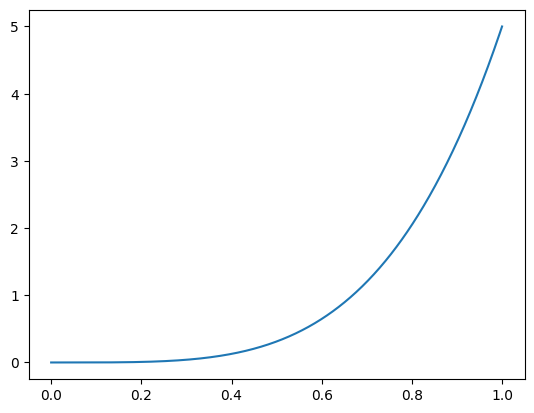

In [27]:
import matplotlib.pyplot as plt
import numpy as np


def plot_function(f, tmin, tmax, tlabel=None, xlabel=None, axes=False, **kwargs):
    ts = np.linspace(tmin, tmax, 1000)
    if tlabel:
        plt.xlabel(tlabel, fontsize=18)
    if xlabel:
        plt.ylabel(xlabel, fontsize=18)
    plt.plot(ts, [f(t) for t in ts], **kwargs)
    if axes:
        total_t = tmax - tmin
        plt.plot([tmin - total_t / 10, tmax + total_t / 10], [0, 0], c='k', linewidth=1)
        plt.xlim(tmin - total_t / 10, tmax + total_t / 10)
        xmin, xmax = plt.ylim()
        plt.plot([0, 0], [xmin, xmax], c='k', linewidth=1)
        plt.ylim(xmin, xmax)


def p(x):
    return x ** 5


# plot_function(derivative(p))
plot_function(lambda x: 5 * x ** 4, 0, 1)

**exec2**:  我们可以把只有1个变量的函数 看做1个向量空间 .

根据求导的法则: 导数是这个向量空间的 线性变换 !.

如果把 f 和 g 看作向量. 把导数写成函数 D

$$
D(f + g) = Df + Dg
$$

而且
$$
D(c\cdot f) = c \cdot Df
$$

因此对 是封闭的, 可以看作是一个线性空间 .

**exec3** : 找出 f(x)/g(x) 的导数公式

把前面的简单合并就行 .

$$
\frac {f^{'}(x)g(x) - f(x)g^{'}(x)} {g(x)^2}
$$

**exec4**: 计算 f(g(h(x))) 对 x 的导数

需要2次应用链式法则 .

$$
f^{'}(x) \cdot g^{'}(h(x)) \cdot f^{'}(g(h(x)))
$$

## 4. 自动计算导数

依旧是靠代码 .
源码在 d3/expressions.py 中. 就是把之前的知识硬编码进去

## 5. 符号化积分函数

不定积分就是 导数的逆运算 .

一个导数的逆运算 有无限个， 因为 常熟不影响求导 .

$$
\int cos(x) \mathrm {d} x =  sin(x) + C
$$

$$
\int 3x^2 \mathrm{d} x = x^3 + C
$$

还有一些特别难的

$$
\int tan(x) \mathrm{d} x
$$

还有一些算不出来的. 也就是不可积分的 .

$$
f(x) = e ^{x^2}
$$


python 有一些库帮助我们做了很多事情 .
例如 `SymPy` 库就一个开源的 Python 符号数学库 . 他有自己的表达式结构 .

- 而且重载了 运算符.  比我们做的工作多了很多

In [28]:
from sympy import *
from sympy.core.core import *

Mul(Symbol('y'), Add(3, Symbol('x')))

y*(x + 3)

In [29]:
y = Symbol('y')

In [30]:
x = Symbol('x')

In [31]:
y * (3 + x)

y*(x + 3)

In [32]:
y * (3 + x).subs(x, 1)

4*y

In [33]:
(x ** 2).diff(x)  # 求导

2*x

In [34]:
(3 * x ** 2).integrate(x)  # 积分

x**3

### exercises

**exec1**: f(x) = 0 的积分是多少 .

In [35]:
x = Symbol('x')
# Integer(0) 表示的是 数 0 的表达式
Integer(0).integrate(x)

0

**exec2:** xcos(x) 的积分是 ?

In [36]:
(x * cos(x)).integrate(x)

x*sin(x) + cos(x)

## 总结

- 将代数表达式建模为数据结构而不是代码字符串， 可以让你编写程序来回答更多关于表达式的问题
- 在代码中对代数表达式进行建模的 自然方式 是作为树来处理
    - 树的节点可以分为独立表达式 单元
- 通过递归遍历每1个表达式树， 可以回答关于它的一些问题. 比如它包含哪些变量.
- 如果知道定义 1个函数的表达式， 就可以应用一些法则将其转化为函数的导数表达式 ;
- 如果 python 表达式树中每个组合器对应的导数规则编程 . 就能得到1个自动计算导数表达式的 Python 函数
- symPy 是1个强大的库. 可以处理 代数表达式. 有内置的简化, 替换和导数替换函数 . 还有符号积分函数, 可以用来求函数的不定积分公式 .